In [13]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [14]:
# Parsing Data
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

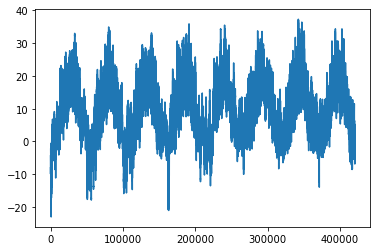

In [15]:
#**Plotting the temperature timeseries**
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

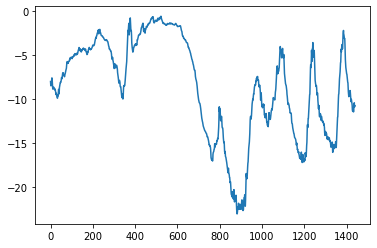

In [16]:
#**Plotting the first 10 days of the temperature timeseries**
plt.plot(range(1440), temperature[:1440])

In [17]:
#**Computing the number of samples we'll use for each data split**
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [18]:
#Normalizing data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

2022-05-08 17:03:20.039309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [20]:
#**Instantiating datasets for training, validation, and testing**
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [22]:
## **Inspecting the output of one of our datasets**
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [24]:
#**Computing the common-sense baseline MAE**
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [25]:
### Let's try a basic machine-learning model

#**Training and evaluating a densely connected model**
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 14s 12ms/step - loss: 12.3725 - mae: 2.7156 - val_loss: 10.8121 - val_mae: 2.5969
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 8.7641 - mae: 2.3255 - val_loss: 13.6115 - val_mae: 2.9388
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 8.1284 - mae: 2.2371 - val_loss: 10.5669 - val_mae: 2.5661
Epoch 4/10
819/819 [==============================] - 9s 10ms/step - loss: 7.7482 - mae: 2.1847 - val_loss: 12.5055 - val_mae: 2.7874
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.4370 - mae: 2.1423 - val_loss: 11.5390 - val_mae: 2.6812
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.2222 - mae: 2.1118 - val_loss: 11.8503 - val_mae: 2.7177
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.0507 - mae: 2.0866 - val_loss: 11.8126 - val_mae: 2.7181
Epoch 8/10
819/819 [==============================] - 9s 11m

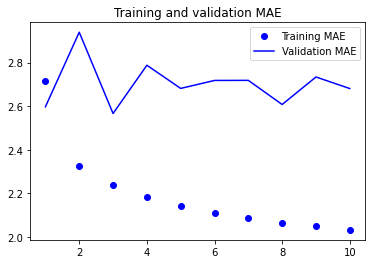

In [26]:
#Ploting Results 
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [27]:
#### Let's try a 1D convolutional model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 29s 34ms/step - loss: 26.1993 - mae: 3.9301 - val_loss: 14.7836 - val_mae: 3.0366
Epoch 2/10
819/819 [==============================] - 25s 31ms/step - loss: 15.6388 - mae: 3.1280 - val_loss: 14.9942 - val_mae: 3.0747
Epoch 3/10
819/819 [==============================] - 25s 30ms/step - loss: 14.5314 - mae: 3.0102 - val_loss: 14.9455 - val_mae: 3.0466
Epoch 4/10
819/819 [==============================] - 25s 30ms/step - loss: 13.7521 - mae: 2.9282 - val_loss: 13.5478 - val_mae: 2.8872
Epoch 5/10
819/819 [==============================] - 25s 30ms/step - loss: 13.0921 - mae: 2.8567 - val_loss: 17.0060 - val_mae: 3.2294
Epoch 6/10
819/819 [==============================] - 25s 31ms/step - loss: 12.5256 - mae: 2.7975 - val_loss: 17.7384 - val_mae: 3.3441
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 12.0898 - mae: 2.7486 - val_loss: 19.2898 - val_mae: 3.4928
Epoch 8/10
819/819 [============================

In [29]:
### A first recurrent baseline
#**A simple LSTM-based model**

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 38s 44ms/step - loss: 41.6561 - mae: 4.7140 - val_loss: 13.7812 - val_mae: 2.7743
Epoch 2/10
819/819 [==============================] - 37s 45ms/step - loss: 11.2443 - mae: 2.6100 - val_loss: 9.9671 - val_mae: 2.4464
Epoch 3/10
819/819 [==============================] - 37s 45ms/step - loss: 9.9708 - mae: 2.4723 - val_loss: 9.7877 - val_mae: 2.4318
Epoch 4/10
819/819 [==============================] - 38s 47ms/step - loss: 9.5472 - mae: 2.4126 - val_loss: 9.8009 - val_mae: 2.4374
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 9.2446 - mae: 2.3716 - val_loss: 9.8910 - val_mae: 2.4466
Epoch 6/10
819/819 [==============================] - 37s 46ms/step - loss: 8.9324 - mae: 2.3317 - val_loss: 9.8236 - val_mae: 2.4418
Epoch 7/10
819/819 [==============================] - 37s 45ms/step - loss: 8.7251 - mae: 2.3084 - val_loss: 9.8086 - val_mae: 2.4303
Epoch 8/10
819/819 [==============================] - 37s 4

In [30]:
## Understanding recurrent neural networks
#**NumPy implementation of a simple RNN**

import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)


In [31]:
### A recurrent layer in Keras
#**An RNN layer that can process sequences of any length**
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [32]:
#**An RNN layer that returns only its last output step**

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [33]:
#**An RNN layer that returns its full output sequence**

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [34]:
#**Stacking RNN layers**
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)


In [35]:
## Advanced use of recurrent neural networks
### Using recurrent dropout to fight overfitting
#**Training and evaluating a dropout-regularized LSTM**

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/50
819/819 [==============================] - 61s 73ms/step - loss: 27.2121 - mae: 3.8586 - val_loss: 9.8398 - val_mae: 2.4396
Epoch 2/50
819/819 [==============================] - 59s 72ms/step - loss: 14.9607 - mae: 3.0032 - val_loss: 9.4647 - val_mae: 2.3855
Epoch 3/50
819/819 [==============================] - 59s 72ms/step - loss: 14.2236 - mae: 2.9274 - val_loss: 9.2565 - val_mae: 2.3656
Epoch 4/50
819/819 [==============================] - 58s 71ms/step - loss: 13.7606 - mae: 2.8721 - val_loss: 9.2583 - val_mae: 2.3601
Epoch 5/50
819/819 [==============================] - 62s 76ms/step - loss: 13.1046 - mae: 2.8092 - val_loss: 9.1627 - val_mae: 2.3454
Epoch 6/50
819/819 [==============================] - 60s 74ms/step - loss: 12.7666 - mae: 2.7759 - val_loss: 9.0454 - val_mae: 2.3313
Epoch 7/50
819/819 [==============================] - 60s 74ms/step - loss: 12.4400 - mae: 2.7369 - val_loss: 8.9676 - val_mae: 2.3272
Epoch 8/50
819/819 [==============================] - 6

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


In [40]:
### Stacking recurrent layers
#**Training and evaluating a dropout-regularized, stacked GRU model**
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 105s 121ms/step - loss: 25.1307 - mae: 3.7006 - val_loss: 9.4886 - val_mae: 2.3768
Epoch 2/50
819/819 [==============================] - 95s 116ms/step - loss: 13.9135 - mae: 2.8875 - val_loss: 8.9550 - val_mae: 2.3149
Epoch 3/50
819/819 [==============================] - 94s 114ms/step - loss: 13.2144 - mae: 2.8162 - val_loss: 9.1636 - val_mae: 2.3510
Epoch 4/50
819/819 [==============================] - 97s 118ms/step - loss: 12.7228 - mae: 2.7647 - val_loss: 8.9941 - val_mae: 2.3298
Epoch 5/50
819/819 [==============================] - 100s 122ms/step - loss: 12.1687 - mae: 2.7052 - val_loss: 8.9120 - val_mae: 2.3135
Epoch 6/50
819/819 [==============================] - 100s 121ms/step - loss: 11.7967 - mae: 2.6651 - val_loss: 9.1995 - val_mae: 2.3546
Epoch 7/50
819/819 [==============================] - 101s 124ms/step - loss: 11.4262 - mae: 2.6240 - val_loss: 9.1669 - val_mae: 2.3486
Epoch 8/50
819/819 [========================

In [44]:
#EXP 02  
### Stacking recurrent layers
#**Training and evaluating a dropout-regularized, stacked GRU model**
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 112s 133ms/step - loss: 24.4308 - mae: 3.6538 - val_loss: 9.5926 - val_mae: 2.4058
Epoch 2/10
819/819 [==============================] - 104s 127ms/step - loss: 13.9654 - mae: 2.8974 - val_loss: 8.7104 - val_mae: 2.2828
Epoch 3/10
819/819 [==============================] - 102s 125ms/step - loss: 13.1803 - mae: 2.8169 - val_loss: 9.4410 - val_mae: 2.3876
Epoch 4/10
819/819 [==============================] - 105s 128ms/step - loss: 12.6252 - mae: 2.7562 - val_loss: 9.1488 - val_mae: 2.3444
Epoch 5/10
819/819 [==============================] - 104s 126ms/step - loss: 12.1010 - mae: 2.6976 - val_loss: 8.7932 - val_mae: 2.3051
Epoch 6/10
819/819 [==============================] - 103s 126ms/step - loss: 11.6554 - mae: 2.6485 - val_loss: 9.3428 - val_mae: 2.3761
Epoch 7/10
819/819 [==============================] - 106s 129ms/step - loss: 11.3616 - mae: 2.6161 - val_loss: 9.5594 - val_mae: 2.4141
Epoch 8/10
819/819 [=====================

In [41]:
### Using bidirectional RNNs
#**Training and evaluating a bidirectional LSTM**
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 51s 58ms/step - loss: 28.1116 - mae: 3.8201 - val_loss: 10.8087 - val_mae: 2.5482
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 10.0873 - mae: 2.4808 - val_loss: 9.6060 - val_mae: 2.3959
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 9.1246 - mae: 2.3476 - val_loss: 9.5160 - val_mae: 2.3781
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 8.5936 - mae: 2.2803 - val_loss: 9.2208 - val_mae: 2.3428
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 8.2264 - mae: 2.2327 - val_loss: 9.2470 - val_mae: 2.3396
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 7.9614 - mae: 2.1979 - val_loss: 9.4355 - val_mae: 2.3743
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 7.6641 - mae: 2.1555 - val_loss: 9.5081 - val_mae: 2.3831
Epoch 8/10
819/819 [==============================] - 48s 5

In [43]:
# exp 01 optimizer="adam"
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 53s 58ms/step - loss: 32.5613 - mae: 4.1372 - val_loss: 13.3591 - val_mae: 2.8078
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 12.0047 - mae: 2.6986 - val_loss: 10.5435 - val_mae: 2.5041
Epoch 3/10
819/819 [==============================] - 47s 58ms/step - loss: 9.9117 - mae: 2.4502 - val_loss: 10.4871 - val_mae: 2.5047
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 9.0642 - mae: 2.3441 - val_loss: 10.2142 - val_mae: 2.4692
Epoch 5/10
819/819 [==============================] - 47s 58ms/step - loss: 8.5484 - mae: 2.2777 - val_loss: 10.0722 - val_mae: 2.4582
Epoch 6/10
819/819 [==============================] - 47s 58ms/step - loss: 8.5979 - mae: 2.2811 - val_loss: 10.0610 - val_mae: 2.4515
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 7.9563 - mae: 2.1950 - val_loss: 9.9885 - val_mae: 2.4437
Epoch 8/10
819/819 [==============================] - 

In [45]:
#Exp 01 optimizer="adam"

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 14s 11ms/step - loss: 13.6677 - mae: 2.8281 - val_loss: 10.4349 - val_mae: 2.5501
Epoch 2/5
819/819 [==============================] - 8s 10ms/step - loss: 8.7953 - mae: 2.3319 - val_loss: 10.4570 - val_mae: 2.5569
Epoch 3/5
819/819 [==============================] - 9s 11ms/step - loss: 7.9980 - mae: 2.2298 - val_loss: 10.3898 - val_mae: 2.5544
Epoch 4/5
819/819 [==============================] - 9s 11ms/step - loss: 7.5197 - mae: 2.1605 - val_loss: 10.8527 - val_mae: 2.6067
Epoch 5/5
405/405 [==============================] - 4s 8ms/step - loss: 11.3075 - mae: 2.6430
Test MAE: 2.64


In [46]:
#EXP 02: optimizer="adadelta" epochs= 10
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adadelta", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 10s 11ms/step - loss: 146.1545 - mae: 10.0614 - val_loss: 125.4319 - val_mae: 9.5376
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 98.3851 - mae: 8.3193 - val_loss: 76.5872 - val_mae: 7.3340
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 67.0116 - mae: 6.7063 - val_loss: 55.2432 - val_mae: 6.0625
Epoch 4/10
819/819 [==============================] - 9s 10ms/step - loss: 53.4260 - mae: 5.8755 - val_loss: 48.3396 - val_mae: 5.6227
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 48.1172 - mae: 5.5514 - val_loss: 45.6717 - val_mae: 5.4337
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 45.1242 - mae: 5.3701 - val_loss: 43.3774 - val_mae: 5.2831
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 42.6499 - mae: 5.2188 - val_loss: 41.1829 - val_mae: 5.1418
Epoch 8/10
819/819 [==============================

In [47]:
#EXP 03 loss = "mape"
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mape", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 10s 12ms/step - loss: 294917.7188 - mae: 6.1421 - val_loss: 80117.0078 - val_mae: 10.0937
Epoch 2/10
819/819 [==============================] - 10s 13ms/step - loss: 488509.2500 - mae: 9.2954 - val_loss: 4963.3389 - val_mae: 12.5919
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 238788.2188 - mae: 9.0770 - val_loss: 1049.3262 - val_mae: 18.2922
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 257924.4062 - mae: 13.0249 - val_loss: 1538.4996 - val_mae: 7.4268
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 131966.7344 - mae: 8.8066 - val_loss: 4265.7031 - val_mae: 6.4671
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 12720.6445 - mae: 6.4604 - val_loss: 1023.0780 - val_mae: 6.5253
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 586.0837 - mae: 6.5166 - val_loss: 981.8972 - val_mae: 6.4932
Epoch 8/10

In [48]:
#EXP04 epochs=10, optimizer="adam",
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 24s 28ms/step - loss: 21.1760 - mae: 3.6107 - val_loss: 14.8359 - val_mae: 3.0500
Epoch 2/10
819/819 [==============================] - 25s 30ms/step - loss: 15.4327 - mae: 3.1030 - val_loss: 17.2232 - val_mae: 3.2983
Epoch 3/10
819/819 [==============================] - 25s 30ms/step - loss: 14.1676 - mae: 2.9683 - val_loss: 14.0738 - val_mae: 2.9698
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 13.3278 - mae: 2.8791 - val_loss: 15.5395 - val_mae: 3.1052
Epoch 5/10
819/819 [==============================] - 24s 29ms/step - loss: 12.7149 - mae: 2.8118 - val_loss: 14.4857 - val_mae: 3.0034
Epoch 6/10
819/819 [==============================] - 24s 29ms/step - loss: 12.2115 - mae: 2.7551 - val_loss: 14.6247 - val_mae: 3.0295
Epoch 7/10
819/819 [==============================] - 24s 30ms/step - loss: 11.7202 - mae: 2.6984 - val_loss: 14.8621 - val_mae: 3.0423
Epoch 8/10
819/819 [============================

In [49]:
#Exp 05 optimizer="adam", epochs=25
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/25
819/819 [==============================] - 44s 49ms/step - loss: 41.8484 - mae: 4.7615 - val_loss: 16.9414 - val_mae: 3.0980
Epoch 2/25
819/819 [==============================] - 39s 47ms/step - loss: 14.0820 - mae: 2.8700 - val_loss: 11.4424 - val_mae: 2.5956
Epoch 3/25
819/819 [==============================] - 39s 48ms/step - loss: 11.5207 - mae: 2.6238 - val_loss: 9.6448 - val_mae: 2.4048
Epoch 4/25
819/819 [==============================] - 38s 46ms/step - loss: 10.3919 - mae: 2.4978 - val_loss: 9.3377 - val_mae: 2.3718
Epoch 5/25
819/819 [==============================] - 39s 47ms/step - loss: 9.7043 - mae: 2.4202 - val_loss: 9.5441 - val_mae: 2.3986
Epoch 6/25
819/819 [==============================] - 37s 45ms/step - loss: 9.0485 - mae: 2.3408 - val_loss: 9.7451 - val_mae: 2.4181
Epoch 7/25
819/819 [==============================] - 44s 54ms/step - loss: 8.8257 - mae: 2.3130 - val_loss: 10.2875 - val_mae: 2.4849
Epoch 8/25
819/819 [==============================] - 3

In [50]:
#Exp 06 optimizer="adagrad" epochs = 50
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adagrad", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 60s 51ms/step - loss: 112.7392 - mae: 8.8961 - val_loss: 94.7441 - val_mae: 8.1475
Epoch 2/50
819/819 [==============================] - 46s 56ms/step - loss: 83.5602 - mae: 7.4764 - val_loss: 76.5890 - val_mae: 7.0293
Epoch 3/50
819/819 [==============================] - 45s 54ms/step - loss: 71.0373 - mae: 6.6600 - val_loss: 68.7589 - val_mae: 6.5043
Epoch 4/50
819/819 [==============================] - 40s 49ms/step - loss: 65.6891 - mae: 6.3330 - val_loss: 64.6092 - val_mae: 6.2631
Epoch 5/50
819/819 [==============================] - 43s 52ms/step - loss: 62.3386 - mae: 6.1370 - val_loss: 61.6055 - val_mae: 6.0891
Epoch 6/50
819/819 [==============================] - 39s 47ms/step - loss: 59.8419 - mae: 5.9914 - val_loss: 59.2482 - val_mae: 5.9518
Epoch 7/50
819/819 [==============================] - 36s 44ms/step - loss: 57.8332 - mae: 5.8740 - val_loss: 57.2550 - val_mae: 5.8337
Epoch 8/50
819/819 [===========================

In [51]:
#EXP07 optimizer = SGD epochs = 15
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="SGD", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 15,
                    validation_data=val_dataset)

Epoch 1/15
819/819 [==============================] - 53s 59ms/step - loss: 11.9889 - mae: 2.6265 - val_loss: 9.0305 - val_mae: 2.3196
Epoch 2/15
819/819 [==============================] - 45s 54ms/step - loss: 9.1046 - mae: 2.3543 - val_loss: 9.2401 - val_mae: 2.3439
Epoch 3/15
819/819 [==============================] - 43s 53ms/step - loss: 8.5334 - mae: 2.2814 - val_loss: 9.3988 - val_mae: 2.3576
Epoch 4/15
819/819 [==============================] - 43s 53ms/step - loss: 8.1476 - mae: 2.2290 - val_loss: 9.4095 - val_mae: 2.3688
Epoch 5/15
819/819 [==============================] - 44s 53ms/step - loss: 7.7962 - mae: 2.1825 - val_loss: 9.8935 - val_mae: 2.4350
Epoch 6/15
819/819 [==============================] - 56s 68ms/step - loss: 7.5163 - mae: 2.1472 - val_loss: 9.9362 - val_mae: 2.4433
Epoch 7/15
819/819 [==============================] - 49s 59ms/step - loss: 7.2081 - mae: 2.1046 - val_loss: 9.6616 - val_mae: 2.3884
Epoch 8/15
819/819 [==============================] - 42s 51m

In [52]:
#EXP08 optimizer = "adamax" , epohcs = 4
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adamax", loss="mae", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=4,
                    validation_data=val_dataset)

Epoch 1/4
819/819 [==============================] - 54s 57ms/step - loss: 4.6875 - mae: 4.6875 - val_loss: 2.8883 - val_mae: 2.8883
Epoch 2/4
819/819 [==============================] - 45s 55ms/step - loss: 2.7891 - mae: 2.7891 - val_loss: 2.5778 - val_mae: 2.5778
Epoch 3/4
819/819 [==============================] - 52s 64ms/step - loss: 2.5546 - mae: 2.5546 - val_loss: 2.4950 - val_mae: 2.4950
Epoch 4/4
819/819 [==============================] - 49s 59ms/step - loss: 2.4563 - mae: 2.4563 - val_loss: 2.4392 - val_mae: 2.4392


In [53]:
#EXP 09 loss = "mse "
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 51s 58ms/step - loss: 39.1416 - mae: 4.6199 - val_loss: 15.4524 - val_mae: 3.0327
Epoch 2/10
819/819 [==============================] - 50s 60ms/step - loss: 13.8594 - mae: 2.8983 - val_loss: 11.9208 - val_mae: 2.7028
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 11.3110 - mae: 2.6414 - val_loss: 10.6017 - val_mae: 2.5429
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 10.2037 - mae: 2.5011 - val_loss: 10.0023 - val_mae: 2.4707
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 9.7194 - mae: 2.4323 - val_loss: 9.8166 - val_mae: 2.4393
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 9.4261 - mae: 2.3942 - val_loss: 9.5862 - val_mae: 2.4105
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 9.2163 - mae: 2.3686 - val_loss: 9.4517 - val_mae: 2.3909
Epoch 8/10
819/819 [==============================] - 

In [54]:
#EXP 09 activation = 'selu'
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="selu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="selu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="selu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 [==============================] - 29s 30ms/step - loss: 22.0895 - mae: 3.6883 - val_loss: 20.3507 - val_mae: 3.6119
Epoch 2/3
819/819 [==============================] - 24s 29ms/step - loss: 15.5612 - mae: 3.1367 - val_loss: 15.9878 - val_mae: 3.1642
Epoch 3/3
405/405 [==============================] - 4s 9ms/step - loss: 17.1812 - mae: 3.2719
Test MAE: 3.27
